In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.utils import shuffle, class_weight
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

### Read data

In [3]:
df_selected = pd.read_csv('./data/df_selected.csv')

In [4]:
df_selected.describe()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,...,application_type,acc_open_past_24mths,mort_acc,pub_rec_bankruptcies,tax_liens,disbursement_method,issue_month,issue_year,earliest_cr_year,credit_history
count,457484.000000,457484.000000,457484.000000,457484.000000,457484.000000,457484.00000,457484.000000,457484.000000,457484.000000,457484.000000,...,457484.000000,457484.000000,457484.000000,457484.000000,457484.000000,457484.000000,457484.000000,457484.000000,457484.000000,457484.000000
mean,14560.685237,14560.685237,14555.374765,42.118666,13.297232,440.29019,1.844924,11.201323,5.766084,2.397426,...,0.003296,4.811952,1.773319,0.148659,0.056844,0.000026,5.567150,2014.678907,1998.224187,16.454720
std,8536.329074,8536.329074,8533.034966,10.459931,4.526475,254.19396,1.331678,6.579267,3.724258,1.425130,...,0.057319,3.156273,2.083654,0.398301,0.420798,0.005122,3.395717,0.786727,7.472356,7.430867
min,1000.000000,1000.000000,900.000000,36.000000,5.320000,14.01000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2014.000000,1944.000000,3.000000
25%,8000.000000,8000.000000,8000.000000,36.000000,9.990000,256.23000,1.000000,6.000000,2.000000,1.000000,...,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,3.000000,2014.000000,1994.000000,11.000000
50%,12400.000000,12400.000000,12400.000000,36.000000,12.990000,378.20000,2.000000,11.000000,6.000000,3.000000,...,0.000000,4.000000,1.000000,0.000000,0.000000,0.000000,5.000000,2015.000000,2000.000000,15.000000
75%,20000.000000,20000.000000,20000.000000,60.000000,15.990000,580.73000,3.000000,15.000000,10.000000,4.000000,...,0.000000,6.000000,3.000000,0.000000,0.000000,0.000000,9.000000,2015.000000,2003.000000,20.000000
max,40000.000000,40000.000000,40000.000000,60.000000,30.990000,1714.54000,6.000000,34.000000,10.000000,4.000000,...,1.000000,53.000000,47.000000,12.000000,85.000000,1.000000,11.000000,2017.000000,2014.000000,70.000000


In [12]:

def plot_feature(df, col_name, isContinuous):
    """
    Visualize a variable with and without faceting on the loan status.
    - col_name is the variable name in the dataframe
    - full_name is the full variable name
    - continuous is True if the variable is continuous, False otherwise
    """
    f, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,3), dpi=90)
    
    # Plot without loan status
    if isContinuous:
        sns.distplot(df.loc[df[col_name].notnull(), col_name], kde=False, ax=ax1)
    else:
        sns.countplot(df[col_name], order=sorted(df[col_name].unique()), color='#5975A4', saturation=1, ax=ax1)
    ax1.set_xlabel(col_name)
    ax1.set_ylabel('Count')
    ax1.set_title(col_name)
    plt.xticks(rotation = 90)

    # Plot with loan status
    if isContinuous:
        sns.boxplot(x=col_name, y='loan_status', data=df, ax=ax2)
        ax2.set_ylabel('')
        ax2.set_title(col_name + ' by Loan Status')
    else:
        data = df.groupby(col_name)['loan_status'].value_counts(normalize=True).to_frame('proportion').reset_index()        
        sns.barplot(x = col_name, y = 'proportion', hue= "loan_status", data = data, saturation=1, ax=ax2)
        ax2.set_ylabel('Loan fraction')
        ax2.set_title('Loan status')
        plt.xticks(rotation = 90)
    ax2.set_xlabel(col_name)
    
    plt.tight_layout()

In [6]:
features = pd.DataFrame([], columns = ['feature name', 'unique values'])
for i, col in enumerate(df_selected.columns):
    features.loc[i] = [col, len(np.unique(df_selected[col]))]

In [7]:
features.sort_values('unique values')

,feature name,unique values
24,initial_list_status,2
25,application_type,2
3,term,2
30,disbursement_method,2
12,loan_status,2
11,verification_status,2
32,issue_year,3
9,home_ownership,5
6,grade,7
28,pub_rec_bankruptcies,11


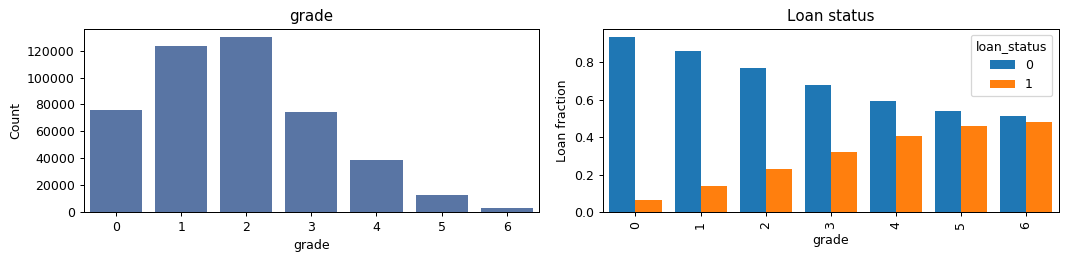

In [13]:
plot_feature(df_selected, 'grade', False)

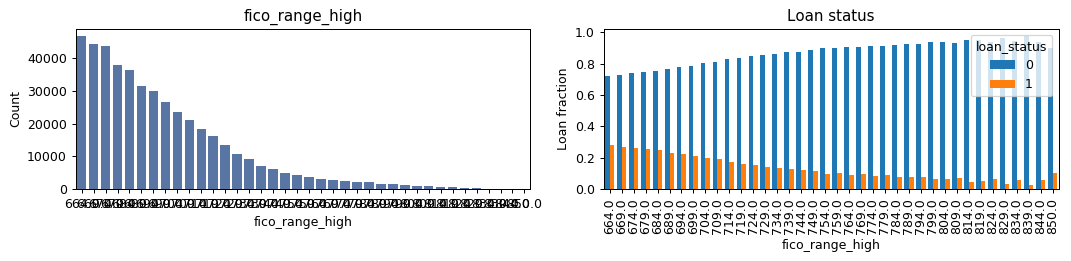

In [16]:
plot_feature(df_selected, 'fico_range_high', False)

### Feature correlations

In [8]:
corr = df_selected.corr()

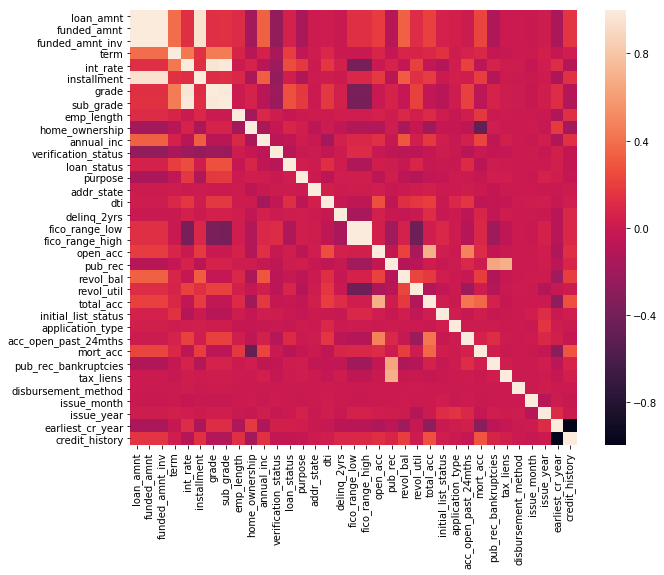

In [9]:
plt.figure(figsize = (10, 8))
sns.heatmap(corr)
plt.show()

In [10]:
corr['loan_status'].sort_values(ascending = False)

loan_status             1.000000
sub_grade               0.275054
grade                   0.269940
int_rate                0.255399
term                    0.193636
dti                     0.123988
acc_open_past_24mths    0.097327
home_ownership          0.078022
revol_util              0.076245
loan_amnt               0.056580
funded_amnt             0.056580
funded_amnt_inv         0.056509
earliest_cr_year        0.038295
installment             0.033007
open_acc                0.031772
purpose                 0.018426
delinq_2yrs             0.018098
pub_rec                 0.015691
pub_rec_bankruptcies    0.011628
tax_liens               0.007703
addr_state              0.003556
disbursement_method     0.001453
issue_month            -0.001010
issue_year             -0.001905
initial_list_status    -0.011397
total_acc              -0.012873
application_type       -0.015694
revol_bal              -0.018513
emp_length             -0.029140
credit_history         -0.038710
annual_inc

### Find highly correlated features

In [27]:
def find_high_correlated_features(frame):
    new_corr = frame.corr()
    new_corr.loc[:,:] = np.tril(new_corr, k=-1) # below main lower triangle of an array
    new_corr = new_corr.stack()
    print(new_corr[(new_corr > 0.4) | (new_corr < -0.4)])

In [28]:
df_selected.drop(['funded_amnt','funded_amnt_inv'], axis=1, inplace=True)

In [29]:
df_selected['avg_fico_score'] = (df_selected['fico_range_high'] + df_selected['fico_range_low'])/2.0

In [30]:
df_selected.drop(['avg_fico_score','fico_range_high'], axis=1, inplace=True)

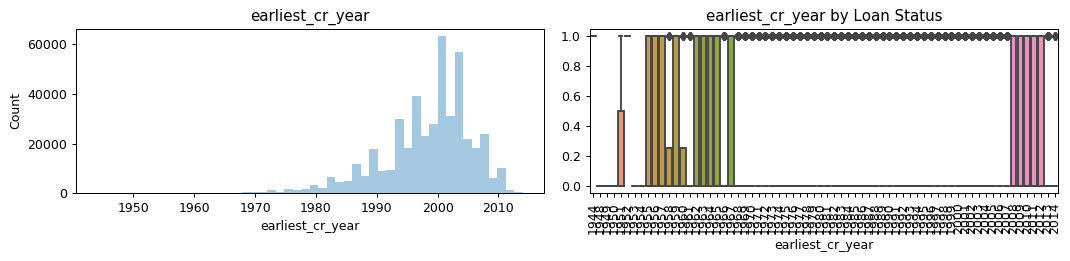

In [31]:
plot_feature(df_selected, 'earliest_cr_year', True)

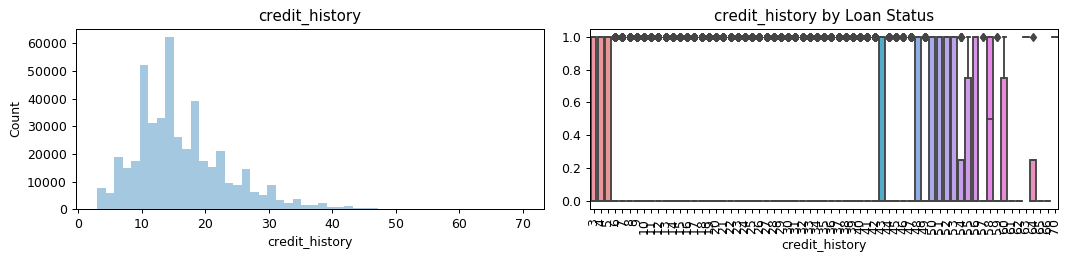

In [32]:
plot_feature(df_selected, 'credit_history', True)

In [33]:
df_selected.drop('earliest_cr_year', axis = 1, inplace=True)

In [34]:
find_high_correlated_features(df_selected)

int_rate              term              0.435879
installment           loan_amnt         0.952673
grade                 term              0.446887
                      int_rate          0.962951
sub_grade             term              0.454138
                      int_rate          0.985559
                      grade             0.976940
revol_util            fico_range_low   -0.429507
total_acc             open_acc          0.689583
acc_open_past_24mths  open_acc          0.482634
                      total_acc         0.428877
mort_acc              home_ownership   -0.477745
pub_rec_bankruptcies  pub_rec           0.642983
tax_liens             pub_rec           0.695931
dtype: float64


### Observe the selected features

In [35]:
df_selected.shape

(457484, 31)

In [36]:
df_selected.head()

,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,annual_inc,verification_status,...,initial_list_status,application_type,acc_open_past_24mths,mort_acc,pub_rec_bankruptcies,tax_liens,disbursement_method,issue_month,issue_year,credit_history
0,3600.0,36,7.49,111.97,0,3,10,1,120000.0,1,...,1,0,13.0,0.0,1.0,0.0,0,7,2017,25
1,35000.0,60,25.49,1037.38,4,23,10,1,114000.0,0,...,1,0,2.0,4.0,0.0,0.0,0,7,2017,19
2,17000.0,36,7.49,528.73,0,3,10,1,120000.0,1,...,1,0,3.0,2.0,1.0,0.0,0,7,2017,12
3,10000.0,36,11.49,329.72,1,9,10,3,145000.0,1,...,1,0,8.0,1.0,0.0,0.0,0,7,2017,12
4,5000.0,36,14.99,173.31,2,13,10,4,68000.0,1,...,0,0,2.0,0.0,0.0,0.0,0,7,2017,14


### Save selected features

In [138]:
df_selected.to_csv('df_model.csv')